In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


print(train_df.head().to_string(index=False))
print(test_df.head().to_string(index=False))


 Id         MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed       parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  peroxide  hydroperoxide  carbonylperoxyacid  nitroester    pSat_Pa
  0  30.010565           4       1       1       0               0          1              1 apin_decane_toluene                   0                             0                 0         1       0                0      0                  0        0      0                  0                      0         0              0                   0           0 641974.491
  1  74.995643           6       1       3       1               0          1              1             toluene                   0                             0                 0         0       0                0      0                  0        0      1       

In [3]:

# missing values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

print(missing_values_train.to_frame().T.to_string(index=False))
print(missing_values_test.to_frame().T.to_string(index=False))


 Id  MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed  parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  peroxide  hydroperoxide  carbonylperoxyacid  nitroester  pSat_Pa
  0   0           0       0       0       0               0          0              0            206                   0                             0                 0         0       0                0      0                  0        0      0                  0                      0         0              0                   0           0        0
 Id  MW  NumOfAtoms  NumOfC  NumOfO  NumOfN  NumHBondDonors  NumOfConf  NumOfConfUsed  parentspecies  C.C..non.aromatic.  C.C.C.O.in.non.aromatic.ring  hydroxyl..alkyl.  aldehyde  ketone  carboxylic.acid  ester  ether..alicyclic.  nitrate  nitro  aromatic.hydroxyl  carbonylperoxynitrate  per

missing values parentspecies, maybe something can be done?

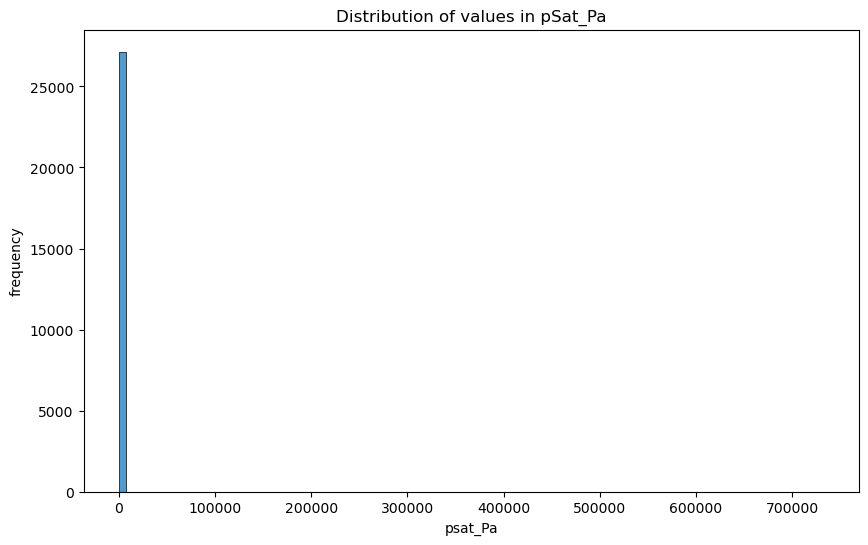

In [4]:


# distribution of pSat_Pa
plt.figure(figsize=(10, 6))
sns.histplot(train_df['pSat_Pa'], bins=100)
plt.title('Distribution of values in pSat_Pa')
plt.xlabel('psat_Pa')
plt.ylabel('frequency')
plt.show()


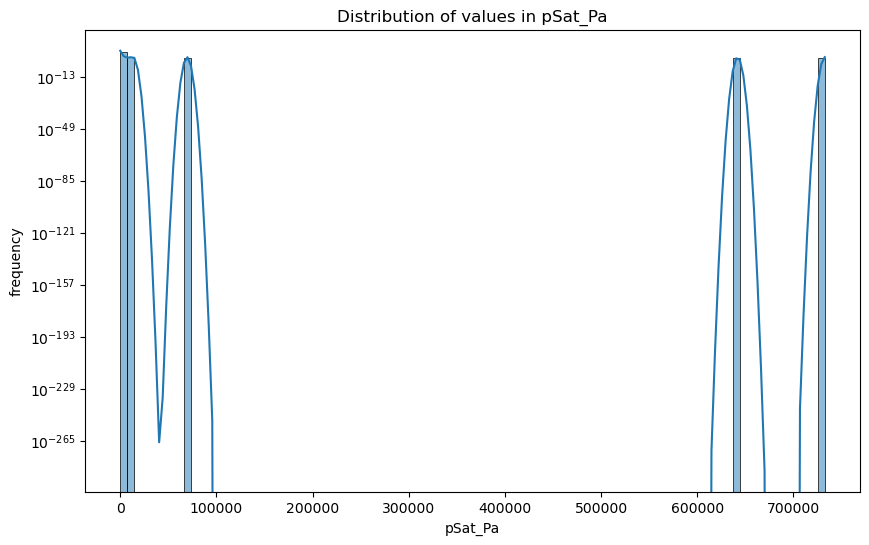

In [5]:

# with log scale y-axis with kde to estimate distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['pSat_Pa'], bins=100, kde=True)
plt.title('Distribution of values in pSat_Pa')

plt.ylabel('frequency')
plt.yscale('log')
plt.show()


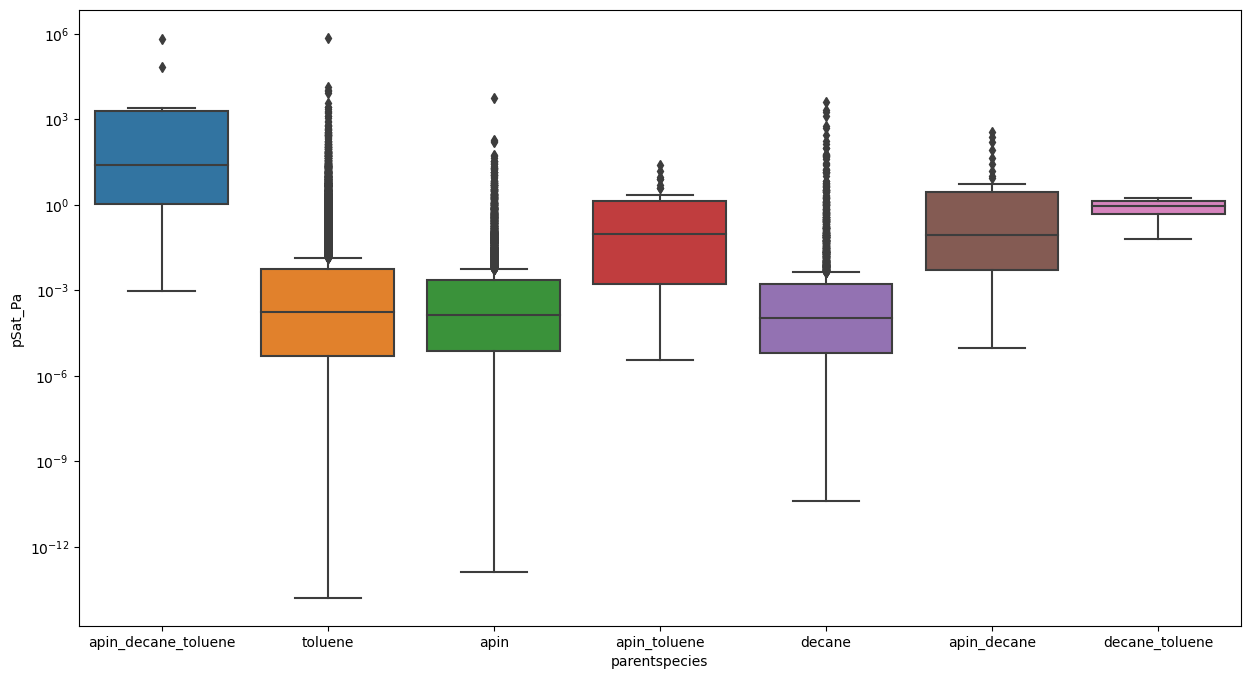

In [6]:
# Check parent species affect on pSat_Pa
plt.figure(figsize=(15, 8))
sns.boxplot(train_df, x='parentspecies', y='pSat_Pa')
plt.yscale('log')
plt.show()


In [7]:


# processing the data ----------------------------------------------
# log transform + adding  constant to avoid log(0)
train_df['pSat_Pa_log'] = np.log(train_df['pSat_Pa'] + 1e-10)

# parentspecies is a categorical variable -> one-hot encoding
# scaling the numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), train_df.select_dtypes(include=['float64', 'int64']).columns.drop(['Id', 'pSat_Pa', 'pSat_Pa_log'])),
        ('cat', OneHotEncoder(), ['parentspecies'])
    ])

# Splitting the data into training and validation sets
X = train_df.drop(columns=['Id', 'pSat_Pa', 'pSat_Pa_log'])
y = train_df['pSat_Pa_log']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Transform the validation data
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

X_train_preprocessed.shape, X_val_preprocessed.shape


((21717, 32), (5430, 32))

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

rf_model = RandomForestRegressor(random_state=1)
gb_model = GradientBoostingRegressor(random_state=1)

# Random forest
rf_model.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_model.predict(X_val_preprocessed)
r2_rf = r2_score(y_val, y_pred_rf)

# Gradient boosting
gb_model.fit(X_train_preprocessed, y_train)
y_pred_gb = gb_model.predict(X_val_preprocessed)
r2_gb = r2_score(y_val, y_pred_gb)

r2_rf, r2_gb


(0.7202038086110971, 0.732411451956821)